# Using the XBBG module to extract and analyze historic bond data for corporate hybrids

# written by: Darren Lefcoe
Jul 2020

contact:
* gitHub: @dlefcoe
* twitter: @dlefcoe
* email: darren@redhedge.uk


## Redhedge Asset Management

Darren Lefcoe uses open source to create and write code for RedHedge.

Running an open source project, like any human endeavor, involves uncertainty and trade-offs.

Please refer to the open source licences:
https://opensource.guide/notices/


# First we do the imports

In [908]:
import os
import sys

import time
import datetime
import collections

import blpapi
from xbbg import blp


import openpyxl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn import linear_model
import numpy as np



In [909]:
# given limit for bloomberg data
bloombergLimit = 500_000



In [910]:
# get the file path of this file
dir_path = os.path.abspath('')



In [913]:
# define a list of bond fields
fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
            'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
            'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody',
             'rtg_sp','yas_mod_dur','workout_dt_years_tdy']




In [914]:
# define bond list

# get items from sheet (in the same folder)
fileToGet = 'hybridSecurityList.xlsx'

# join file and correct folder
fileToGet = os.path.join(dir_path, fileToGet)
secListXlsx = pd.ExcelFile(fileToGet)

# the names of the available sheets
print('getting security list from:', secListXlsx.sheet_names)



getting security list from: ['worksheets', 'tickers']


In [915]:

# put bond list into a pandas dataframe
df = pd.DataFrame(secListXlsx.parse('tickers'))




# Lets see the bond list data

In [916]:
df


,QJ937853 Corp,XS1323897485,SOLBBB 5.118 PERP nc-21
0,EJ917655 Corp,XS0992293901,SOLBBB 5.425 PERP nc-23
1,AV915324 Corp,BE6309987400,SOLBBB 4 1/4 PERP nc-23
2,QJ937566 Corp,XS1323897725,SOLBBB 5.869 PERP nc-24
3,EK834863 Corp,DE000A14J611,BAYNGR 2 3/8 04/02/75 nc-22
4,EK352403 Corp,DE000A11QR73,BAYNGR 3 3/4 07/01/74 nc-24
...,...,...,...
180,EK523297 Corp,DE000A1ZN206,WIEAV 5 PERP nc-21
181,AM679347 Corp,XS1582433428,TRAFIG 6 7/8 PERP nc-21
182,AZ920495 Corp,XS2033327854,TRAFIG 7 1/2 PERP nc-24
183,AO262498 Corp,XS1642682410,SOFTBK 6 PERP nc-23


# A function to get the bond data

In [918]:
def getListDataFromBbg(securtiyList, fieldList):
    ''' 
    gets data from bloomberg using a while loop until completion

        inputs:
            securtiyList - list of tickers to obtain
            fieldList - the fields requested for each ticker

        output:
            resultsOfDataReq - resulting pandas array of the data that was requested

    '''
    # get the data (bdp returns a dataframe)
    resultsOfDataReq = blp.bdp(tickers=securtiyList, flds=fieldList)

    
    #pre-loop initialization
    keepLooping = True
    loopingCounter = 0
    while keepLooping:
        
        # check which items are missing
        listError = list(set(securtiyList)-set(resultsOfDataReq.index.values))
        
        if len(listError) == 0:
            # data collection process finished
            keepLooping = False
            break
        else:
            print(len(listError), 'of', len(securtiyList), 'remaining', ': loop', loopingCounter)
            loopingCounter += 1
            if loopingCounter > 10:
                # more than 10 tries at data collection
                keepLooping = False
                break

        # get and append more data
        try:
            nextChunk = blp.bdp(tickers=listError, flds=fieldList)
            resultsOfDataReq = resultsOfDataReq.append(nextChunk)
        except:
            print('no data to add')

        # remove duplicates
        resultsOfDataReq = resultsOfDataReq.drop_duplicates()

    return resultsOfDataReq

#%time
    

# There are 2 ways of getting history

- from bloomberg
- from a file


## Get historic bond data from BBG
### This works for equity, but not bond data.  Checking with BBG & stack.

https://stackoverflow.com/questions/63230341/from-xbbg-import-blp-works-for-equity-but-does-not-work-for-bonds




In [919]:
def getHistoryExample():
    '''
    fucction to get historic isin history from BBG
    '''

    # return equity data
    eqData = blp.bdh(
        tickers='SPX Index', flds=['high', 'low', 'last_price'],
        start_date='2018-10-10', end_date='2018-10-20',
        )

    print(eqData)

    print('')
    print('getting bond data...')

    # return bond data
    bondData = blp.bdh(
        tickers='XS1152338072 Corp', flds=['px_bid', 'px_ask', 'blp_i_sprd_mid'],
        start_date='2019-10-10', end_date='2019-10-20',
        )

    print(bondData)
    # print(bondData.columns)

    return 


getHistoryExample()


           SPX Index                    
                high      low last_price
2018-10-10   2874.02  2784.86    2785.68
2018-10-11   2795.14  2710.51    2728.37
2018-10-12   2775.77  2729.44    2767.13
2018-10-15   2775.99  2749.03    2750.79
2018-10-16   2813.46  2766.91    2809.92
2018-10-17   2816.94  2781.81    2809.21
2018-10-18   2806.04  2755.18    2768.78
2018-10-19   2797.77  2760.27    2767.78

getting bond data...
           XS1152338072 Corp                        
                      px_bid   px_ask blp_i_sprd_mid
2019-10-10           103.495  103.948         79.928
2019-10-11           103.522  103.963         77.704
2019-10-14           103.537  103.958         76.124
2019-10-15           103.540  103.963         74.418
2019-10-16           103.530  103.966         72.720
2019-10-17           103.568  103.996         69.392
2019-10-18           103.534  103.984         69.708


In [920]:
def getHistoryFromISIN(isin: str):
    '''
    function that takes an isin as a string and returns a DataFrame for the ISIN 
    '''

    # get dates to use (in the correct format)
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)

    # fields that we want to get
    fieldList = ['px_bid', 'px_ask', 'blp_i_sprd_mid']
    #fieldList = ['blp_i_sprd_mid']

    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin+' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )


    return bondDataHist
bondDataHist = getHistoryFromISIN('XS1152338072')
bondDataHist





lets go between today and 2 years ago
today: 2020-08-13
2y ago: 2018-08-14


XS1152338072 Corp                        
                      px_bid   px_ask blp_i_sprd_mid
2018-08-14           103.617  104.083        127.266
2018-08-15           103.567  104.083        128.759
2018-08-16           103.570  104.081        127.930
2018-08-17           103.504  104.070        129.257
2018-08-20           103.521  104.059        129.557
...                      ...      ...            ...
2020-08-07           101.226  101.997        108.732
2020-08-10           101.287  102.006        100.973
2020-08-11           101.263  102.043        100.188
2020-08-12           101.329  102.020         97.113
2020-08-13           101.389  102.006            NaN

[511 rows x 3 columns]

#### get the average spread

In [921]:

print('the mean is', bondDataHist.mean())
print('the standard deviation is', bondDataHist.std())
#x['blp_i_sprd_mid'].mean()

the mean is XS1152338072 Corp  px_bid            102.531247
                   px_ask            103.102705
                   blp_i_sprd_mid    131.441641
dtype: float64
the standard deviation is XS1152338072 Corp  px_bid             1.599061
                   px_ask             1.483368
                   blp_i_sprd_mid    90.454567
dtype: float64


### plot a time series for the spreads






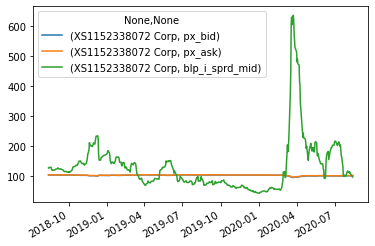

In [922]:
#bondDataHist.plot(x='nxt_call_dt',y='blp_i_sprd_mid')
bondDataHist.plot()

<class 'pandas.core.frame.DataFrame'>
MultiIndex([('XS1152338072 Corp',         'px_bid'),
            ('XS1152338072 Corp',         'px_ask'),
            ('XS1152338072 Corp', 'blp_i_sprd_mid')],
           )


131.44164117647057

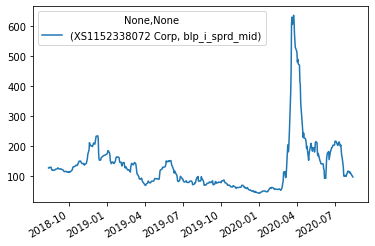

In [923]:
# plot just spread
print(type(bondDataHist))
#bondDataHist.plot(x=, y='blp_i_sprd_mid')

# works
#plt.plot(bondDataHist.index, bondDataHist.values)
# bondDataHist.plot(y='blp_i_sprd_mid', use_index=True)
bondDataHist.plot(y=('XS1152338072 Corp', 'blp_i_sprd_mid'))

# note this is a multi index (whatever that means)
print(bondDataHist.columns)

x = bondDataHist[('XS1152338072 Corp', 'blp_i_sprd_mid')]
x.mean()





## get data for multiple bonds




In [924]:
all_VW_bonds = ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 
                'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']

listOfBonds = all_VW_bonds




In [925]:
def getHistoryFromISIN_list(isin_list: list):
    ''' function to get historic data from a list of isins  '''

    # list of isins
    isin_list = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin_list, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )
    

    return bondDataHist

vwHist = getHistoryFromISIN_list(listOfBonds)
vwHist


here is the list:  ['XS1048428012 Corp', 'XS1206540806 Corp', 'XS1629658755 Corp', 'XS0968913342 Corp', 'XS1799938995 Corp', 'XS2187689034 Corp', 'XS1048428442 Corp', 'XS1629774230 Corp', 'XS1799939027 Corp', 'XS2187689380 Corp', 'XS1206541366 Corp']
lets go between today and 2 years ago
today: 2020-08-13
2y ago: 2018-08-14


,XS0968913342 Corp,XS1048428012 Corp,XS1048428442 Corp,XS1206540806 Corp,XS1206541366 Corp,XS1629658755 Corp,XS1629774230 Corp,XS1799938995 Corp,XS1799939027 Corp,XS2187689034 Corp,XS2187689380 Corp
,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid
2018-08-14,275.872,192.990,322.698,257.486,337.200,269.402,363.093,322.223,369.466,NaN,NaN
2018-08-15,280.494,204.263,329.239,264.258,342.142,274.286,367.595,327.752,373.647,NaN,NaN
2018-08-16,279.291,204.943,329.088,264.568,341.706,276.110,369.770,327.695,372.482,NaN,NaN
2018-08-17,279.517,204.818,329.572,265.858,342.338,275.879,369.730,327.668,372.546,NaN,NaN
2018-08-20,280.095,205.211,330.649,266.012,341.029,276.119,369.272,328.092,372.330,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-06,339.442,215.328,376.451,298.372,404.814,318.083,393.583,365.976,407.801,381.879,408.719
2020-08-07,331.056,188.190,368.451,282.069,396.190,306.101,385.290,356.687,399.783,368.247,399.794
2020-08-10,316.821,169.738,360.126,260.165,390.544,290.412,377.957,346.007,393.856,357.934,394.088


In [926]:
vwHist.describe()


,XS0968913342 Corp,XS1048428012 Corp,XS1048428442 Corp,XS1206540806 Corp,XS1206541366 Corp,XS1629658755 Corp,XS1629774230 Corp,XS1799938995 Corp,XS1799939027 Corp,XS2187689034 Corp,XS2187689380 Corp
,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,44.000000,44.000000
mean,290.615559,223.260765,351.631837,276.905447,355.942178,294.365253,382.209812,337.675778,390.302922,391.585682,416.178455
std,96.527178,149.071888,79.550984,110.355856,63.507173,104.427231,80.696000,93.462337,71.575134,20.121139,15.656231
min,144.402000,64.053000,218.129000,128.812000,258.862000,143.045000,254.274000,185.697000,268.958000,339.868000,379.151000
25%,227.055000,123.730750,307.133500,197.618500,320.750750,219.876000,331.376500,271.288000,345.427750,379.234250,406.170500
50%,271.292500,189.600500,339.754500,258.258500,345.809500,276.924500,378.341500,334.127500,387.656500,398.048500,420.978000
75%,339.508000,262.125000,394.149750,329.755500,382.826750,351.104000,423.493500,392.855500,431.125500,405.947750,427.077250
max,754.996000,860.316000,740.320000,870.351000,730.035000,793.130000,744.702000,768.710000,716.388000,419.973000,442.270000


In [927]:
#extracting data from the DataFrame
#print(vwHist.describe().iloc[0]) # works
#print(vwHist.describe().loc['max']) # works

# get the max of one bond
print('the max is ', vwHist.describe().loc[['max'],[('XS0968913342 Corp',  'blp_i_sprd_mid')]].values)


the max is  [[754.996]]


In [928]:
# save to csv

# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_HistoryStats ' + ts + '.csv'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'csvData', fileToSave)

# export to csv
vwHist.describe().to_csv(fileToSave)
print('file saved here: ', fileToSave)


file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\csvData\bond_isprd_HistoryStats 2020-08-13 11_55_18.csv


the columns
MultiIndex([('XS0968913342 Corp', 'blp_i_sprd_mid'),
            ('XS1048428012 Corp', 'blp_i_sprd_mid'),
            ('XS1048428442 Corp', 'blp_i_sprd_mid'),
            ('XS1206540806 Corp', 'blp_i_sprd_mid'),
            ('XS1206541366 Corp', 'blp_i_sprd_mid'),
            ('XS1629658755 Corp', 'blp_i_sprd_mid'),
            ('XS1629774230 Corp', 'blp_i_sprd_mid'),
            ('XS1799938995 Corp', 'blp_i_sprd_mid'),
            ('XS1799939027 Corp', 'blp_i_sprd_mid'),
            ('XS2187689034 Corp', 'blp_i_sprd_mid'),
            ('XS2187689380 Corp', 'blp_i_sprd_mid')],
           )
the means:
XS0968913342 Corp  blp_i_sprd_mid    290.615559
XS1048428012 Corp  blp_i_sprd_mid    223.260765
XS1048428442 Corp  blp_i_sprd_mid    351.631837
XS1206540806 Corp  blp_i_sprd_mid    276.905447
XS1206541366 Corp  blp_i_sprd_mid    355.942178
XS1629658755 Corp  blp_i_sprd_mid    294.365253
XS1629774230 Corp  blp_i_sprd_mid    382.209812
XS1799938995 Corp  blp_i_sprd_mid    337.675

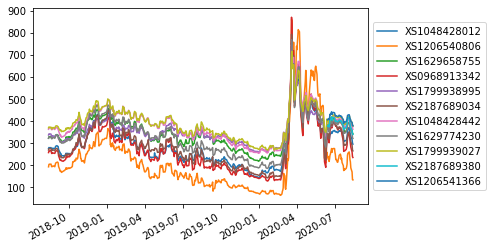

In [929]:
## do some basic stats

print('the columns')
# vwHist.columns=all_VW_bonds
print(vwHist.columns)
print('the means:')
print(vwHist.mean())
print('the st devs:')
print(vwHist.std())

vwHist.plot().legend(all_VW_bonds, loc='center left', bbox_to_anchor=(1.0, 0.5))



# We need the current data (for the names instead of isins)

In [930]:
def getVWbondData(isin_list: list):
    ''' function to get VW bond data '''

    # isins
    isin_list = [i + " Corp" for i in isin_list]

    # fields
    fieldList = ['id_isin', 'security_name', 'name', 'ticker' ,'cpn', 'nxt_call_dt', 'yas_ispread','rtg_moody', 'rtg_sp']

    vwDF = getListDataFromBbg(isin_list,  fieldList)


    return vwDF


vw = getVWbondData(all_VW_bonds)
print(all_VW_bonds)
vw

['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']


,id_isin,security_name,name,ticker,cpn,nxt_call_dt,yas_ispread,rtg_moody,rtg_sp
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,VW,5.125,2023-09-04,293.889,Baa2,BBB-
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,VW,3.75,2021-03-24,129.533,Baa2,BBB-
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2026-03-24,342.345,Baa2,BBB-
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,2.5,2022-03-20,230.494,Baa2,BBB-
XS1206541366 Corp,XS1206541366,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2030-03-20,376.622,Baa2,BBB-
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,VW,2.7,2022-12-14,264.561,Baa2,BBB-
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2027-06-14,362.825,Baa2,BBB-
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.375,2024-06-27,320.79,Baa2,BBB-
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2028-06-27,379.972,Baa2,BBB-
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2025-06-17,340.306,Baa2,BBB-


In [931]:
# add a unique name
vw['uniqueName'] = vw['ticker'] +  " " + vw['cpn'].astype(str) + " -c " + vw['nxt_call_dt'].astype(str).str[2:4]
vw

,id_isin,security_name,name,ticker,cpn,nxt_call_dt,yas_ispread,rtg_moody,rtg_sp,uniqueName
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,VW,5.125,2023-09-04,293.889,Baa2,BBB-,VW 5.125 -c 23
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,VW,3.75,2021-03-24,129.533,Baa2,BBB-,VW 3.75 -c 21
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2026-03-24,342.345,Baa2,BBB-,VW 4.625 -c 26
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,2.5,2022-03-20,230.494,Baa2,BBB-,VW 2.5 -c 22
XS1206541366 Corp,XS1206541366,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2030-03-20,376.622,Baa2,BBB-,VW 3.5 -c 30
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,VW,2.7,2022-12-14,264.561,Baa2,BBB-,VW 2.7 -c 22
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2027-06-14,362.825,Baa2,BBB-,VW 3.875 -c 27
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.375,2024-06-27,320.79,Baa2,BBB-,VW 3.375 -c 24
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2028-06-27,379.972,Baa2,BBB-,VW 4.625 -c 28
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2025-06-17,340.306,Baa2,BBB-,VW 3.5 -c 25


In [932]:
# sort by next call date

print(vw.columns)
print(vw.index)

vwsorted_byDate = vw.sort_values(by='nxt_call_dt')
vwsorted_byDate


Index(['id_isin', 'security_name', 'name', 'ticker', 'cpn', 'nxt_call_dt',
       'yas_ispread', 'rtg_moody', 'rtg_sp', 'uniqueName'],
      dtype='object')
Index(['XS0968913342 Corp', 'XS1048428012 Corp', 'XS1048428442 Corp',
       'XS1206540806 Corp', 'XS1206541366 Corp', 'XS1629658755 Corp',
       'XS1629774230 Corp', 'XS1799938995 Corp', 'XS1799939027 Corp',
       'XS2187689034 Corp', 'XS2187689380 Corp'],
      dtype='object')


,id_isin,security_name,name,ticker,cpn,nxt_call_dt,yas_ispread,rtg_moody,rtg_sp,uniqueName
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,VW,3.75,2021-03-24,129.533,Baa2,BBB-,VW 3.75 -c 21
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,2.5,2022-03-20,230.494,Baa2,BBB-,VW 2.5 -c 22
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,VW,2.7,2022-12-14,264.561,Baa2,BBB-,VW 2.7 -c 22
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,VW,5.125,2023-09-04,293.889,Baa2,BBB-,VW 5.125 -c 23
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.375,2024-06-27,320.79,Baa2,BBB-,VW 3.375 -c 24
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2025-06-17,340.306,Baa2,BBB-,VW 3.5 -c 25
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2026-03-24,342.345,Baa2,BBB-,VW 4.625 -c 26
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2027-06-14,362.825,Baa2,BBB-,VW 3.875 -c 27
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2028-06-27,379.972,Baa2,BBB-,VW 4.625 -c 28
XS2187689380 Corp,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2029-06-17,379.817,Baa2,BBB-,VW 3.875 -c 29


### Here is the VW yield curve

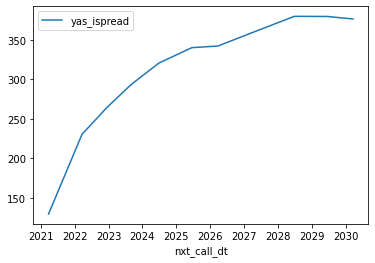

In [933]:
vwsorted_byDate.plot(x='nxt_call_dt', y='yas_ispread')

### merge the historic data to the current data


In [1233]:
# merge table

def mergeDataFramesWithHistorySeries_vw(df1, df2):
    ''' 
    function to merge dataframes
        
    inputs: 
        df1: first dataframe
        df2: second dataframe

    outputs:
        dfOut: output DataFrame

    '''
    

    # Cannot merge a Series without a name => df2 needs to have a name  (solved with rename())
    # ValueError: cannot join with no overlapping index names (solved with droplevel())
    
    #dfOut = df1.merge(df2.rename('mean_2y'),left_index=True, right_index=True)
    dfOut = df1.merge(df2,left_index=True, right_index=True)
    # print('\n\noutput dataframe:')
    
    # print(dfOut)

    return dfOut


# run function (MultiLevel series renamed and dropped to single level)
vw_merged = mergeDataFramesWithHistorySeries_vw(vwsorted_byDate, vwHist.iloc[-180:-1].mean().rename('mean_1y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.mean().rename('mean_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.std().rename('std_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.min().rename('min_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.max().rename('max_2y').droplevel(level=1))

# additional stats to add
vwmean = vwHist.ewm(halflife=0.25).mean().tail(1).transpose().reset_index().set_index('level_0')
vwstd =  vwHist.ewm(halflife=0.25).std().tail(1).transpose().reset_index().set_index('level_0')
#vwstd = pd.ewm(vwHist,halflife=0.5).std().tail(1).transpose().reset_index().set_index('level_0')

del vwmean['level_1']
del vwstd['level_1']
vwmean.columns.values[-1] = 'ewm'
vwstd.columns.values[-1] = 'ewmstd'

vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwmean)
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwstd)


vw_merged




,id_isin,security_name,name,ticker,cpn,nxt_call_dt,yas_ispread,rtg_moody,rtg_sp,uniqueName,mean_1y,mean_2y,std_2y,min_2y,max_2y,ewm,ewmstd
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,VW,3.75,2021-03-24,129.533,Baa2,BBB-,VW 3.75 -c 21,283.375022,223.260765,149.071888,64.053,860.316,133.828828,6.884854
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,2.5,2022-03-20,230.494,Baa2,BBB-,VW 2.5 -c 22,310.146598,276.905447,110.355856,128.812,870.351,235.574243,5.448537
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,VW,2.7,2022-12-14,264.561,Baa2,BBB-,VW 2.7 -c 22,321.408894,294.365253,104.427231,143.045,793.130,265.499497,5.268338
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,VW,5.125,2023-09-04,293.889,Baa2,BBB-,VW 5.125 -c 23,319.045704,290.615559,96.527178,144.402,754.996,296.120687,4.927658
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.375,2024-06-27,320.79,Baa2,BBB-,VW 3.375 -c 24,348.439458,337.675778,93.462337,185.697,768.710,321.915536,5.182705
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2025-06-17,340.306,Baa2,BBB-,VW 3.5 -c 25,392.788419,391.585682,20.121139,339.868,419.973,340.161792,4.275543
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2026-03-24,342.345,Baa2,BBB-,VW 4.625 -c 26,365.349687,351.631837,79.550984,218.129,740.320,342.631889,3.634004
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2027-06-14,362.825,Baa2,BBB-,VW 3.875 -c 27,390.471000,382.209812,80.696000,254.274,744.702,363.712261,3.145029
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2028-06-27,379.972,Baa2,BBB-,VW 4.625 -c 28,393.455994,390.302922,71.575134,268.958,716.388,378.631518,3.317933
XS2187689380 Corp,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2029-06-17,379.817,Baa2,BBB-,VW 3.875 -c 29,417.039558,416.178455,15.656231,379.151,442.270,379.338849,3.156758


### Add column to DataFrame for z-score + adjustments

In [1262]:
# add column to index

# list of differences
vw_merged['ispread-mean-1y'] = vw_merged['yas_ispread'] - vw_merged['mean_1y']
vw_merged['ispread-mean'] = vw_merged['yas_ispread'] - vw_merged['mean_2y']
vw_merged['z-score'] = vw_merged['ispread-mean'] / vw_merged['std_2y']
vw_merged['z-score-EWM'] = (vw_merged['yas_ispread']-vw_merged['ewm']) / vw_merged['ewmstd']
vw_merged['percentile'] = ((vw_merged['yas_ispread'] - vw_merged['min_2y']) / (vw_merged['max_2y'] - vw_merged['min_2y'])) 


# column for adjusted yield curve
# reset adjustment
mrkt_assumption_resetFactor_pct = 10
RH_assumption_resetFactor_pct = 20
resetFactor = -(RH_assumption_resetFactor_pct-mrkt_assumption_resetFactor_pct) / 100 # mrkt assumption: 10%, RH assumption: 20%, 
vw_merged['resetAdjust'] = (vw_merged['yas_ispread'] - vw_merged['yas_ispread'].mean()) * resetFactor
vw_merged['adj-isprd'] = vw_merged['yas_ispread'] + (vw_merged['yas_ispread'] - vw_merged['yas_ispread'].mean()) * resetFactor

#rating adjustment
mrkt_assumption_green_bps = -5
RH_assumption_green_bps = -20
if vw_merged['rtg_sp'].all() == "-":
    print('rating adjustment made')
    rtgAdj = RH_assumption_green_bps - mrkt_assumption_green_bps
else:
    rtgAdj = 0

vw_merged['rtgAdj']=rtgAdj    
vw_merged['adj-isprd'] = vw_merged['adj-isprd'] + rtgAdj

# SP rating adjust
# need to add this.

# fair value based on spread history to benchmark
benchmarkBond='XS1048428442' + ' Corp'
vw_merged['RH fVal Av adj'] = vw_merged['mean_1y']-vw_merged.loc[benchmarkBond,'mean_1y']
vw_merged['RH fVal'] = vw_merged.loc[benchmarkBond,'adj-isprd'] + vw_merged['RH fVal Av adj']
print('1 year iSpread average for benchmark bond',vw_merged.loc[benchmarkBond,'mean_1y'])
    
#vw_merged[['security_name','mean_2y','ispread-mean','yas_ispread','ewm','std_2y','z-score','z-score-EWM']]
vw_merged



1 year iSpread average for benchmark bond 365.34968715083795


,id_isin,security_name,name,ticker,cpn,nxt_call_dt,yas_ispread,rtg_moody,rtg_sp,uniqueName,...,ispread-mean-1y,ispread-mean,z-score,z-score-EWM,percentile,resetAdjust,adj-isprd,rtgAdj,RH fVal Av adj,RH fVal
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,VW,3.75,2021-03-24,129.533,Baa2,BBB-,VW 3.75 -c 21,...,-153.842,-93.7281,-0.628744,-0.623997,0.0822338,18.1481,147.681,0,-81.974665,257.237581
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,2.5,2022-03-20,230.494,Baa2,BBB-,VW 2.5 -c 22,...,-79.6526,-46.4114,-0.420561,-0.932397,0.137123,8.05199,238.546,0,-55.203089,284.009157
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,VW,2.7,2022-12-14,264.561,Baa2,BBB-,VW 2.7 -c 22,...,-56.848,-29.8043,-0.285408,-0.178156,0.186923,4.64531,269.206,0,-43.940793,295.271453
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,VW,5.125,2023-09-04,293.889,Baa2,BBB-,VW 5.125 -c 23,...,-25.1567,3.27345,0.0339122,-0.452888,0.244822,1.7125,295.602,0,-46.303983,292.908263
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.375,2024-06-27,320.79,Baa2,BBB-,VW 3.375 -c 24,...,-27.6494,-16.8857,-0.180669,-0.217158,0.231715,-0.977609,319.812,0,-16.910229,322.302017
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2025-06-17,340.306,Baa2,BBB-,VW 3.5 -c 25,...,-52.4828,-51.28,-2.54857,0.0336459,0.00546341,-2.92917,337.376,0,27.438731,366.650977
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2026-03-24,342.345,Baa2,BBB-,VW 4.625 -c 26,...,-23.0043,-9.28645,-0.116736,-0.0788394,0.237875,-3.13314,339.212,0,0.000000,339.212246
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2027-06-14,362.825,Baa2,BBB-,VW 3.875 -c 27,...,-27.6458,-19.3846,-0.240218,-0.282053,0.22134,-5.18112,357.644,0,25.121313,364.333559
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2028-06-27,379.972,Baa2,BBB-,VW 4.625 -c 28,...,-13.4842,-10.3311,-0.144339,0.403953,0.248114,-6.89578,373.076,0,28.106307,367.318553
XS2187689380 Corp,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2029-06-17,379.817,Baa2,BBB-,VW 3.875 -c 29,...,-37.2223,-36.3612,-2.32248,0.151544,0.0105552,-6.88033,372.937,0,51.689871,390.902117


In [1257]:
# works better for historical data
vw_merged.describe()


,mean_1y,mean_2y,std_2y,min_2y,max_2y,ewm,ewmstd,rtgAdj,RH fVal Av adj,RH fVal
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,11.000000
mean,356.017887,337.333972,80.450105,216.841000,712.835545,312.070176,4.443828,0.0,-9.331800,329.880446
std,42.547488,59.349209,38.484443,94.932343,147.973563,75.823810,1.198667,0.0,42.547488,42.547488
min,283.375022,223.260765,15.656231,64.053000,419.973000,133.828828,3.145029,0.0,-81.974665,257.237581
25%,320.227299,292.490406,67.541154,143.723500,723.211500,280.810092,3.475969,0.0,-45.122388,294.089858
50%,365.349687,351.631837,80.696000,218.129000,744.702000,340.161792,4.275543,0.0,0.000000,339.212246
75%,391.629709,386.256367,100.477204,263.910000,780.920000,369.534550,5.225521,0.0,26.280022,365.492268
max,417.039558,416.178455,149.071888,379.151000,870.351000,379.338849,6.884854,0.0,51.689871,390.902117


In [1297]:
# prepare dataframe for chart output
chartDF = pd.DataFrame(vw_merged)
#chartDF = chartDF.drop(columns=['ticker','cpn','nxt_call_dt','security_name','name', 'rtg_moody','rtg_sp'], axis=1)

chartDF = chartDF.reset_index(drop=True)
chartDF = chartDF[['id_isin','uniqueName','mean_2y','std_2y','min_2y','max_2y','yas_ispread','ispread-mean','z-score',
                   'percentile','resetAdjust','adj-isprd', 'RH fVal Av adj', 'RH fVal']]
chartDF = chartDF.round({'mean_2y': 0, 'std_2y': 0, 'min_2y':0,'max_2y':0,'ewm':0,'yas_ispread':1,'ispread-mean':0,'adj-isprd':0})
chartDF['yas_ispread'] = chartDF['yas_ispread'].astype(float).round(0)
chartDF['ispread-mean'] = chartDF['ispread-mean'].astype(float).round(0)
chartDF['z-score'] = chartDF['z-score'].astype(float).round(1)
chartDF['percentile'] = chartDF['percentile'].astype(float).round(3)
chartDF['adj-isprd'] = chartDF['adj-isprd'].astype(float).round(0)
chartDF['resetAdjust'] = chartDF['resetAdjust'].astype(float).round(0)
chartDF['RH fVal Av adj'] = chartDF['RH fVal Av adj'].astype(float).round(0)
chartDF['RH fVal'] = chartDF['RH fVal'].astype(float).round(0)

#print(len(chartDF.columns))
print('DF shape:',chartDF.shape)
chartDF





DF shape: (11, 14)


,id_isin,uniqueName,mean_2y,std_2y,min_2y,max_2y,yas_ispread,ispread-mean,z-score,percentile,resetAdjust,adj-isprd,RH fVal Av adj,RH fVal
0,XS1048428012,VW 3.75 -c 21,223.0,149.0,64.0,860.0,130.0,-94.0,-0.6,0.082,18.0,148.0,-82.0,257.0
1,XS1206540806,VW 2.5 -c 22,277.0,110.0,129.0,870.0,230.0,-46.0,-0.4,0.137,8.0,239.0,-55.0,284.0
2,XS1629658755,VW 2.7 -c 22,294.0,104.0,143.0,793.0,265.0,-30.0,-0.3,0.187,5.0,269.0,-44.0,295.0
3,XS0968913342,VW 5.125 -c 23,291.0,97.0,144.0,755.0,294.0,3.0,0.0,0.245,2.0,296.0,-46.0,293.0
4,XS1799938995,VW 3.375 -c 24,338.0,93.0,186.0,769.0,321.0,-17.0,-0.2,0.232,-1.0,320.0,-17.0,322.0
5,XS2187689034,VW 3.5 -c 25,392.0,20.0,340.0,420.0,340.0,-51.0,-2.5,0.005,-3.0,337.0,27.0,367.0
6,XS1048428442,VW 4.625 -c 26,352.0,80.0,218.0,740.0,342.0,-9.0,-0.1,0.238,-3.0,339.0,0.0,339.0
7,XS1629774230,VW 3.875 -c 27,382.0,81.0,254.0,745.0,363.0,-19.0,-0.2,0.221,-5.0,358.0,25.0,364.0
8,XS1799939027,VW 4.625 -c 28,390.0,72.0,269.0,716.0,380.0,-10.0,-0.1,0.248,-7.0,373.0,28.0,367.0
9,XS2187689380,VW 3.875 -c 29,416.0,16.0,379.0,442.0,380.0,-36.0,-2.3,0.011,-7.0,373.0,52.0,391.0


### plot the new data

In [1306]:
# colours / conditional formatting


# createDF of same size with zero's
coloursDF = chartDF.replace(chartDF,0)
coloursDF.loc[:,:]='white'
#coloursDF.loc[:,'percentile']='red'
coloursDF['percentile']= chartDF['percentile']
coloursDF.loc[chartDF['percentile'] > 0.7, 'percentile'] = 'orange'
coloursDF.loc[chartDF['percentile'] < 0.7, 'percentile'] = 'white'
coloursDF.loc[chartDF['percentile'] < 0.1, 'percentile'] = 'lightcyan'


coloursDF.loc[(chartDF['adj-isprd']-chartDF['yas_ispread']) > 10, 'adj-isprd'] = 'green'
coloursDF.loc[(chartDF['adj-isprd']-chartDF['yas_ispread']) < -10, 'adj-isprd'] = 'red'

coloursDF.loc[chartDF['z-score'] < -1, 'z-score'] = 'orange'
coloursDF.loc[chartDF['z-score'] < -2, 'z-score'] = 'red'
coloursDF.loc[chartDF['z-score'] > 1, 'z-score'] = 'green'
coloursDF.loc[chartDF['z-score'] > 2, 'z-score'] = 'blue'

coloursDF.loc[chartDF['std_2y'] == chartDF['std_2y'].values.min(), 'std_2y'] = 'skyblue'
coloursDF.loc[chartDF['std_2y'] == chartDF['std_2y'].values.max(), 'std_2y'] = 'pink'


print('shape: ',coloursDF.shape)
coloursDF

#pd.DataFrame(index=range(numRows),columns=range(numCols))

shape:  (11, 14)


,id_isin,uniqueName,mean_2y,std_2y,min_2y,max_2y,yas_ispread,ispread-mean,z-score,percentile,resetAdjust,adj-isprd,RH fVal Av adj,RH fVal
0,white,white,white,pink,white,white,white,white,white,lightcyan,white,green,white,white
1,white,white,white,white,white,white,white,white,white,white,white,white,white,white
2,white,white,white,white,white,white,white,white,white,white,white,white,white,white
3,white,white,white,white,white,white,white,white,white,white,white,white,white,white
4,white,white,white,white,white,white,white,white,white,white,white,white,white,white
5,white,white,white,white,white,white,white,white,red,lightcyan,white,white,white,white
6,white,white,white,white,white,white,white,white,white,white,white,white,white,white
7,white,white,white,white,white,white,white,white,white,white,white,white,white,white
8,white,white,white,white,white,white,white,white,white,white,white,white,white,white
9,white,white,white,skyblue,white,white,white,white,red,lightcyan,white,white,white,white


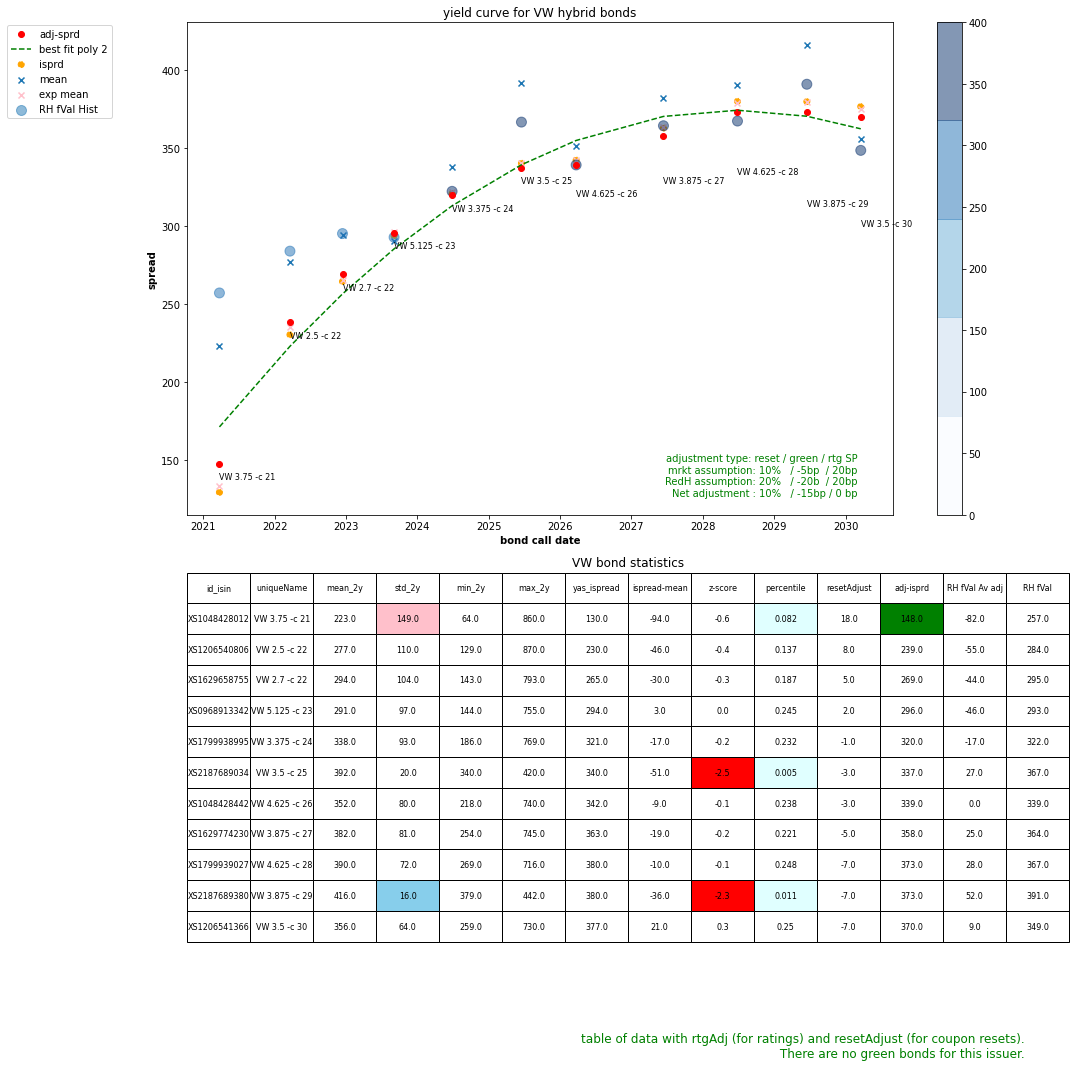

the file is saved here:
C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\pdfData\adjusted yld curve 2020-08-14 19_38_32.pdf


In [1407]:
fig, ax = plt.subplots(2,1, figsize=(15,15), tight_layout=True)

cmap = mpl.cm.get_cmap('Blues',5)

ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['yas_ispread'], marker='o', label='isprd', ls='-.', color='orange')
ax[0].plot(vw_merged['nxt_call_dt'], vw_merged['adj-isprd'], marker='o', label='adj-sprd',  linestyle='', color='red')
ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['mean_2y'], marker='x', label = 'mean')
ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['ewm'], marker='x', label = 'exp mean', color = 'pink')
cax = ax[0].scatter(x=vw_merged['nxt_call_dt'], y=vw_merged['RH fVal'], marker='o', s=100,
              label = 'RH fVal Hist', c=vw_merged['RH fVal'], cmap=cmap, vmin=0, vmax=400, alpha=0.5)

fig.colorbar(cax, ax=ax[0])


# ax[0].set_label('Color Intensity')

ax[0].xaxis.set_label_text('bond call date', weight='bold')
ax[0].yaxis.set_label_text('spread', weight='bold')
ax[0].title.set_text('yield curve for VW hybrid bonds')

# colours


# plot a table
#pd.plotting.table(ax[1],chartDF,loc='center', colWidths=[0.1]*2 + [0.05]*(len(chartDF.columns)-2)).set_fontsize('large')
#ax[1].table(cellText=chartDF.values, colLabels=chartDF.columns, bbox=[0,0.25,1,0.75],cellLoc='center')#.auto_set_font_size(False)
the_table = ax[1].table(cellText=chartDF.values, colLabels=chartDF.columns, bbox=[0,0.25,1,0.75],
                        cellLoc='center',cellColours=coloursDF.values)
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1, 1)
ax[1].title.set_text('example dataframe with plot')
ax[1].axis('off')


# label the points
for i, txt in enumerate(vw_merged['uniqueName'].values):
    n = 10
    if i == 6:
        n=20    
    if i == 7:
        n=30
    if i == 8:
        n=40
    if i==9:
        n=60
    if i==10:
        n=70
    ax[0].annotate(txt, (vw_merged['nxt_call_dt'][i], vw_merged['adj-isprd'][i]-n), fontsize=8)

# adjustments comment
adjComment =               'adjustment type: reset / green / rtg SP\n'
adjComment =  adjComment + f'mrkt assumption: {mrkt_assumption_resetFactor_pct}%   / {mrkt_assumption_green_bps}bp  / 20bp\n'
adjComment =  adjComment + f'RedH assumption: {RH_assumption_resetFactor_pct}%   / {RH_assumption_green_bps}b  / 20bp\n'
adjComment =  adjComment + f'Net adjustment : {(RH_assumption_resetFactor_pct-mrkt_assumption_resetFactor_pct)}%   / {RH_assumption_green_bps-mrkt_assumption_green_bps}bp / 0 bp\n'
    
# anotate the chart
ax[0].text(0.95, 0.01, adjComment,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0].transAxes,
        color='green', fontsize=10)



# anotate the table
ax[1].text(0.95, 0.01, 'table of data with rtgAdj (for ratings) and resetAdjust (for coupon resets).\n There are no green bonds for this issuer.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1].transAxes,
        color='green', fontsize=12)


# add RH fair value curve


# line of best fit
# first convert datetime to numbers
#dateIntegers = [int (i.strftime('%Y%m%d')) for i in vw_merged['nxt_call_dt'].values]
dateIntegers = pd.to_datetime(vw_merged['nxt_call_dt']).values.astype(float)


y = vw_merged['adj-isprd'].values.tolist()
bestFit = np.polyfit(dateIntegers, vw_merged['adj-isprd'].values.tolist(), 2)

p = np.poly1d(bestFit)
ax[0].plot(vw_merged['nxt_call_dt'],p(dateIntegers),  linestyle='--', color='green', label='best fit poly 2')

ax[0].legend(loc='center right', bbox_to_anchor=(-0.1, 0.9))
plt.title('VW bond statistics')
plt.show()


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'adjusted yld curve ' + ts + '.pdf'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'pdfData', fileToSave)


fig.tight_layout()
fig.savefig(fileToSave)
print('the file is saved here:')
print(fileToSave)


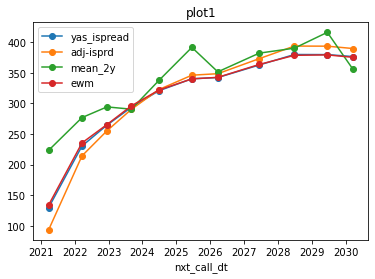

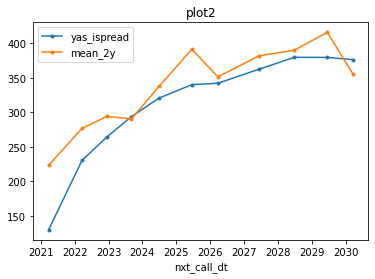

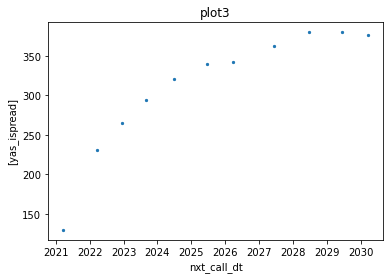

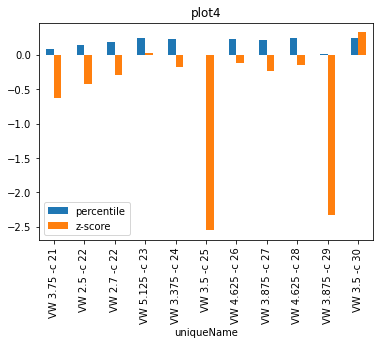

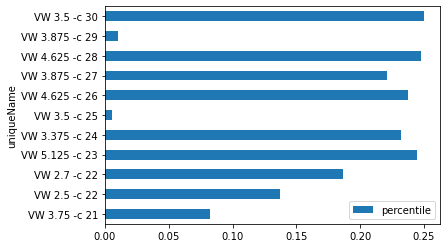

In [940]:
# plot data
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread', 'adj-isprd','mean_2y', 'ewm'], marker='o', title="plot1")
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread','mean_2y'], marker='.', title="plot2")
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread'], kind='scatter', marker='.', title="plot3")
vw_merged.plot(x='uniqueName', y=['percentile', 'z-score'] ,kind='bar', title="plot4")
vw_merged.plot(x='uniqueName', y='percentile' ,kind='barh')


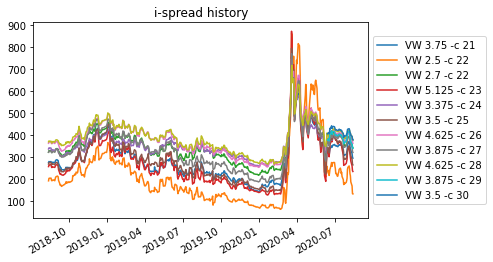

In [941]:
# Plot history with correct labels


ax = vwHist.plot()
# list of bonds
#print(vw_merged[['id_isin','security_name']])

# prepare legend list
legendList = []
for i in all_VW_bonds:
    counter = 0
    for j in vw_merged['id_isin']:
        if j == i:
            #print(i, j, vw_merged['security_name'][counter], counter)
            legendList.append(vw_merged['uniqueName'][counter])  #security_name

        counter = counter + 1

# print(legendList)


# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.legend(legendList, loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('i-spread history')
ax


### box and whisker plot

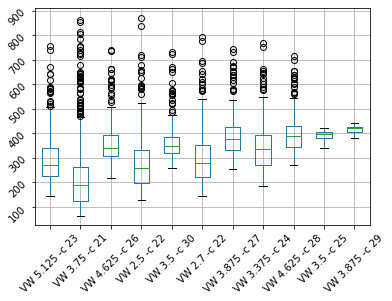

In [942]:
#df = pd.DataFrame(vwHist[('XS1206541366 Corp', 'blp_i_sprd_mid')].values, columns=['this'])
#df['that']=vwHist[('XS1799939027 Corp', 'blp_i_sprd_mid')].values
df = pd.DataFrame(vwHist[vwHist.columns].values, columns=vw['uniqueName'].values)
df

boxplot = df.boxplot(column=vw['uniqueName'].values.tolist()).tick_params(labelrotation=45)

### subplots

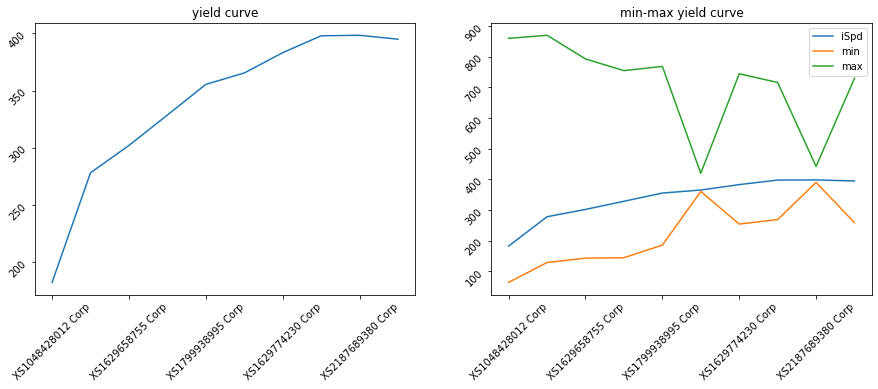

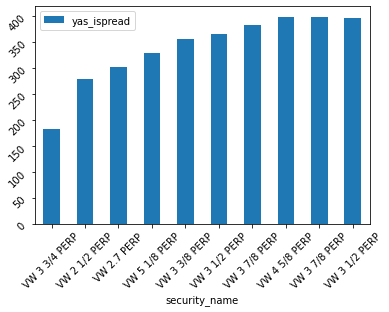

In [111]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )

vw_merged['yas_ispread'].plot(ax=axes[0])
vw_merged['yas_ispread'].plot(ax=axes[1])
vw_merged['min_2y'].plot(ax=axes[1])
vw_merged['max_2y'].plot(ax=axes[1])

axes[0].set_title('yield curve')
axes[0].tick_params(labelrotation=45)
axes[1].legend(['iSpd','min','max'])
axes[1].set_title('min-max yield curve')
axes[1].tick_params(labelrotation=45)

vw_merged[['security_name', 'yas_ispread']].plot(x='security_name', y='yas_ispread', kind='bar').tick_params(labelrotation=45)



# Spread to Benchmark History
Define a benchmark bond and get the spread to benchmark history for all other bonds in the list.

In [208]:
def spreadToBenchmarkHistory(isinBench: str, isin_list: list):
    """
    define a benchmark bond and get spread to benchmark hiistory for bonds in hthe list.
    
        input:
            isinBench: the benchmark isin
            isin_list: the benchmark isins list
            
        output:
            df: dataframe containing benchmark histories
            
    """
    
    # remove benchmark from list
    if isinBench in isin_list:
        print('isin removed')
        isin_list.remove(isinBench)
    else:
        print('isin not in bench')
    

    # list of isins
    isin_list_corp = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)
    

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object - for the isin list    
    bondDataHist = blp.bdh(
        tickers= isin_list_corp, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # request from bbg returning a MultiIndex DataFrame object - for the isin benchmark  
    benchDataHist = blp.bdh(
        tickers= isinBench+ ' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # MultiIndex dataframe for spreads
    spreadDataHist = bondDataHist.sub(benchDataHist[(isinBench+ ' Corp', 'blp_i_sprd_mid')], axis=0)
    
    # print(spreadDataHist)
    # rename columns
    spreadDataHist.columns = isin_list
    
    
    return spreadDataHist


benchmarkBond = 'XS1048428442'
vw_spd_to_bmk_hist = spreadToBenchmarkHistory(benchmarkBond, listOfBonds)


#print(type(vw_spd_to_bmk))
#vw_spd_to_bmk.rename(columns={"('XS0968913342 Corp', 'blp_i_sprd_mid')": 'testBond'}, inplace=True)
vw_spd_to_bmk_hist





isin not in bench
here is the list:  ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 'XS2187689034', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']
lets go between today and 2 years ago
today: 2020-08-10
2y ago: 2018-08-11


,XS1048428012,XS1206540806,XS1629658755,XS0968913342,XS1799938995,XS2187689034,XS1629774230,XS1799939027,XS2187689380,XS1206541366
2018-08-13,-45.498,-128.794,-63.664,17.740,-51.055,41.337,1.065,49.254,NaN,NaN
2018-08-14,-46.826,-129.708,-65.212,14.502,-53.296,40.395,-0.475,46.768,NaN,NaN
2018-08-15,-48.745,-124.976,-64.981,12.903,-54.953,38.356,-1.487,44.408,NaN,NaN
2018-08-16,-49.797,-124.145,-64.520,12.618,-52.978,40.682,-1.393,43.394,NaN,NaN
2018-08-17,-50.055,-124.754,-63.714,12.766,-53.693,40.158,-1.904,42.974,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-08-03,-21.001,-131.783,-50.539,19.941,-40.946,14.999,3.191,29.433,25.777,36.845
2020-08-04,-25.223,-143.202,-60.707,23.324,-49.385,15.673,-1.014,30.244,17.085,33.073
2020-08-05,-32.435,-155.807,-68.774,25.329,-55.996,16.585,-10.240,30.255,8.257,31.142
2020-08-06,-37.009,-161.123,-78.079,28.363,-58.368,17.132,-10.475,31.350,5.428,32.268


## A summary of all the time series data

In [412]:
vw_spd_to_bmk_hist.describe()

,XS1048428012,XS1206540806,XS1629658755,XS0968913342,XS1799938995,XS2187689034,XS1629774230,XS1799939027,XS2187689380,XS1206541366
count,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,41.000000,41.000000
mean,-61.081183,-127.930829,-74.530010,4.171510,-57.153311,30.661311,-13.901965,38.711648,8.175463,31.808171
std,23.017525,81.805641,35.796972,25.459694,29.613054,14.650142,20.649454,15.091829,7.239115,6.186866
min,-101.353000,-225.360000,-144.986000,-45.356000,-113.143000,-3.703000,-55.157000,-40.961000,-0.724000,23.601000
25%,-75.497500,-168.274500,-96.097750,-20.028750,-77.643000,20.490750,-32.083750,30.818250,3.331000,26.503000
50%,-68.819000,-149.966500,-81.471000,3.681000,-61.312000,26.923500,-10.032000,40.242500,5.428000,30.562000
75%,-47.764500,-128.688750,-57.490500,29.875250,-41.429250,40.532000,2.600000,47.517500,11.814000,36.231000
max,14.676000,192.901000,130.031000,50.411000,52.810000,69.802000,29.022000,70.439000,25.777000,43.257000


In [444]:
# save to csv

# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_toBMK_HistoryStats ' + ts + '.csv'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'csvData', fileToSave)

# export to csv
vw_spd_to_bmk_hist.describe().to_csv(fileToSave)
print('CSV file saved here: ', fileToSave)


# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_toBMK_HistoryStats ' + ts + '.xlsx'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'xlsxData', fileToSave)

# export to xlsx
vw_spd_to_bmk_hist.describe().to_excel(fileToSave)
print('XLSX file saved here: ', fileToSave)




CSV file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\csvData\bond_isprd_toBMK_HistoryStats 2020-08-11 13_37_24.csv
XLSX file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\xlsxData\bond_isprd_toBMK_HistoryStats 2020-08-11 13_37_24.xlsx


<class 'matplotlib.axes._subplots.AxesSubplot'>


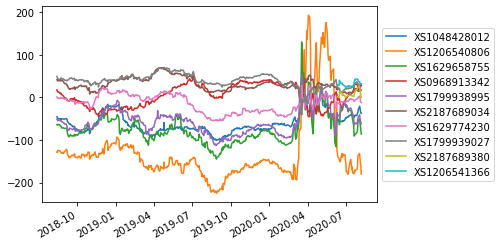

In [209]:
# plot this

ax = vw_spd_to_bmk_hist.plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.tight_layout()
ax

print(type(ax))

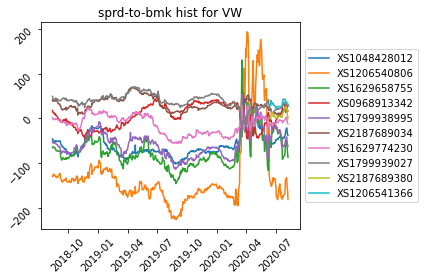

In [210]:
# method 2 for plotting
fig, ax = plt.subplots()
ax.plot(vw_spd_to_bmk_hist)
ax.title.set_text('sprd-to-bmk hist for VW')
ax.legend(vw_spd_to_bmk_hist.columns, loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.tick_params(labelrotation=45)
fig.tight_layout()

# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'spreadImage ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



In [211]:
# give columns nice names

vw_spread_list = [] # list to store names
for i in vw_spd_to_bmk.columns:
    vw_spread_list.append(vw_merged.loc[vw_merged['id_isin'] == i, 'uniqueName'].item())
    
print(vw_spread_list)
# print(type(vw_spread_list))    
    

['VW 3.75 -c 21', 'VW 2.5 -c 22', 'VW 2.7 -c 22', 'VW 5.125 -c 23', 'VW 3.375 -c 24', 'VW 3.5 -c 25', 'VW 3.875 -c 27', 'VW 4.625 -c 28', 'VW 3.875 -c 29', 'VW 3.5 -c 30']


### examples of histograms

##### one specific bond

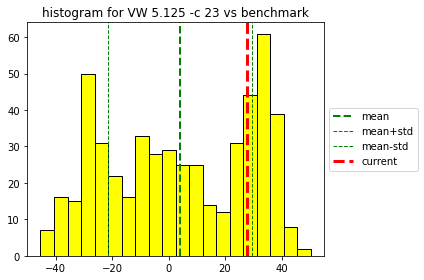

the isin number is:  XS0968913342
the mean spread is:  4.2
the stdev spread is:  25.5
the current spread is:  27.7
--------------------
the file is saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\charts\XS09689133422020-08-12 10_36_52.png


In [514]:
#print(type(vw_spd_to_bmk[('XS0968913342 Corp','blp_i_sprd_mid')]))
bond_to_plot = 'XS0968913342'
bond_name = vw_merged.loc[vw_merged['id_isin'] == bond_to_plot, 'uniqueName'].item()
#vw_spd_to_bmk_hist[(bond_to_plot)].hist(bins=20, color='yellow',edgecolor='k')
fig, ax = plt.subplots()
plt.hist(vw_spd_to_bmk_hist[(bond_to_plot)],bins=20, color='yellow',edgecolor='k')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].mean(), color='green', linestyle='dashed', linewidth=2, label='mean')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].mean()+vw_spd_to_bmk_hist[('XS0968913342')].std(), color='green', linestyle='dashed', linewidth=1, label='mean+std')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].mean()-vw_spd_to_bmk_hist[('XS0968913342')].std(), color='green', linestyle='dashed', linewidth=1, label='mean-std')
plt.axvline(vw_spd_to_bmk_hist[(bond_to_plot)].values[-1], color='red', linestyle='dashed', linewidth=3, label='current')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)
plt.title(f'histogram for {bond_name} vs benchmark')
plt.tight_layout()
plt.show()

print('the isin number is: ', bond_to_plot)
print('the mean spread is: ',round(vw_spd_to_bmk_hist[('XS0968913342')].mean(),1))
print('the stdev spread is: ',round(vw_spd_to_bmk_hist[('XS0968913342')].std(),1))
print('the current spread is: ', round(vw_spd_to_bmk_hist[('XS0968913342')].values[-1],1))
print('--------------------')


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = bond_to_plot + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)
print('the file is saved here: ', fileToSave)


##### all the bonds (multi plot)

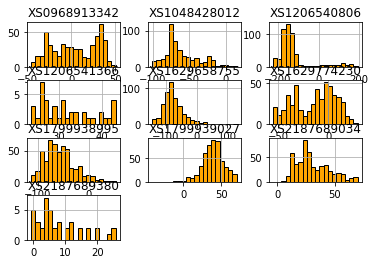

In [473]:
vw_spd_to_bmk.hist(bins=20, color='orange',edgecolor='k')  #.subplots_adjust(hspace=0)
plt.show()

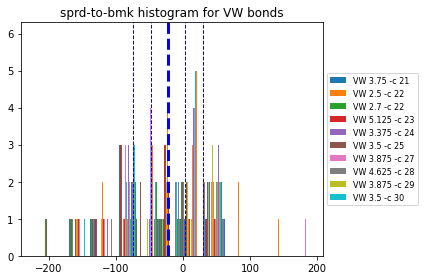

the mean is:  -22.1
the st dev is:  26.0


In [538]:

fig, ax = plt.subplots(tight_layout=True)

ax.hist(vw_spd_to_bmk)
#ax.legend(vw_spd_to_bmk.columns)
ax.legend(vw_spread_list, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=8)
ax.title.set_text('sprd-to-bmk histogram for VW bonds')

ax.axvline(vw_spd_to_bmk.mean().mean(), color='blue', linestyle='dashed', linewidth=3, label='mean')
ax.axvline(vw_spd_to_bmk.mean().mean()+vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+std')
ax.axvline(vw_spd_to_bmk.mean().mean()-vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+std')
ax.axvline(vw_spd_to_bmk.mean().mean()+2*vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+2*std')
ax.axvline(vw_spd_to_bmk.mean().mean()-2*vw_spd_to_bmk.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+2*std')

#fig.tight_layout()
#vw_spd_to_bmk.mean()

plt.show()

print('the mean is: ', round(vw_spd_to_bmk.mean().mean(),1))
print('the st dev is: ', round(vw_spd_to_bmk.std().mean(),1))



### some statistics

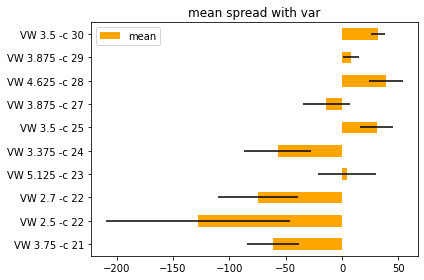

In [411]:

# print('the mean is: \n', vw_spd_to_bmk.mean())
# print('the standard deviation is: \n', vw_spd_to_bmk.std())



vw_spd_to_bmk.mean().plot(kind='barh', label='mean', color='orange', 
                          xerr=vw_spd_to_bmk.std(), 
                          title='mean spread with var').legend(['mean'])
# add dots for current spread
#vw_spd_to_bmk.mean().plot(kind='barh', label='current', color='red').legend(['current'])

plt.yticks(range(len(vw_spread_list)),vw_spread_list)

plt.tight_layout()
plt.show()


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'meanSpreads_and_Variances ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



### some z scores

In [350]:
# zscore is: (value - mean() / std())
vw_spd_to_bmk_df = pd.DataFrame({'bonds':vw_spread_list,'mean_spd_to_bmk':vw_spd_to_bmk.mean(), 'st dev spd_to_bmk':vw_spd_to_bmk.std()})
vw_spd_to_bmk_df['id_isin'] = vw_spd_to_bmk_df.index
#vw_spd_to_bmk_df.merge(vw_merged,how='left', right_on='id_isin')

#x = vw_merged['id_isin'].loc[benchmarkBond]
#print(x)
# x = vw.loc[benchmarkBond+" Corp", 'yas_ispread']
# print(x)

#vw_spd_to_bmk_df['sprd_to_bmk'] = vw_spd_to_bmk_df['yas_ispread']  - vw.loc[benchmarkBond+" Corp", 'yas_ispread']

vw_spd_to_bmk_df = pd.merge(vw_spd_to_bmk_df, vw_merged, on='id_isin')
vw_spd_to_bmk_df['sprd_to_bmk'] = vw_spd_to_bmk_df['yas_ispread']  - vw.loc[benchmarkBond+" Corp", 'yas_ispread']

vw_spd_to_bmk_df['z-score spd_to_bmk'] = (vw_spd_to_bmk_df['sprd_to_bmk']-vw_spd_to_bmk_df['mean_spd_to_bmk'])/vw_spd_to_bmk_df['st dev spd_to_bmk']
vw_spd_to_bmk_df
#vw_merged




,bonds,mean_spd_to_bmk,st dev spd_to_bmk,id_isin,security_name,name,ticker,cpn,nxt_call_dt,yas_ispread,...,std_2y,min_2y,max_2y,ewm,ispread-mean,z-score,percentile,adj-isprd,sprd_to_bmk,z-score spd_to_bmk
0,VW 3.75 -c 21,-61.081183,23.017525,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,VW,3.75,2021-03-24,183.015,...,149.247315,64.053,860.316,195.949659,-40.6424,-0.272316,0.1494,152.308,-177.348,-5.05123
1,VW 2.5 -c 22,-127.930829,81.805641,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,2.5,2022-03-20,274.139,...,110.545514,128.812,870.351,287.293665,-2.91948,-0.0264097,0.19598,261.657,-86.2242,0.509826
2,VW 2.7 -c 22,-74.530010,35.796972,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,VW,2.7,2022-12-14,297.834,...,104.623798,143.045,793.130,309.781767,3.3995,0.0324926,0.238106,290.092,-62.5286,0.335265
3,VW 5.125 -c 23,4.171510,25.459694,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,VW,5.125,2023-09-04,325.111,...,96.711287,144.402,754.996,333.965628,34.6043,0.35781,0.295956,322.824,-35.2516,-1.54845
4,VW 3.375 -c 24,-57.153311,29.613054,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.375,2024-06-27,352.982,...,93.643778,185.697,768.710,359.588904,15.2961,0.163344,0.286932,356.269,-7.38058,1.68077
5,VW 3.5 -c 25,30.661311,14.650142,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2025-06-17,362.989,...,16.483810,360.699,419.973,372.409134,-31.8485,-1.93211,0.0386335,368.277,2.62621,-1.91364
6,VW 3.875 -c 27,-13.901965,20.649454,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2027-06-14,381.259,...,80.851763,254.274,744.702,387.718446,-0.99036,-0.0122491,0.258927,390.201,20.8962,1.68519
7,VW 4.625 -c 28,38.711648,15.091829,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,VW,4.625,2028-06-27,397.723,...,71.718017,268.958,716.388,402.123402,7.42296,0.103502,0.287787,409.958,37.3599,-0.0895705
8,VW 3.875 -c 29,8.175463,7.239115,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,VW,3.875,2029-06-17,397.201,...,13.464429,390.141,442.270,402.408777,-21.2693,-1.57967,0.135431,409.332,36.8381,3.95941
9,VW 3.5 -c 30,31.808171,6.186866,XS1206541366,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,VW,3.5,2030-03-20,393.215,...,63.604240,258.862,730.035,398.518728,37.4552,0.588879,0.285145,404.548,32.852,0.168712


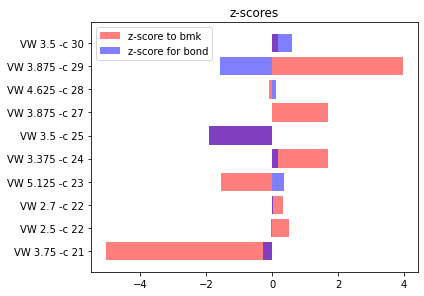

In [405]:
# plot some of the new data

fig, axs = plt.subplots()
axs.barh(vw_spd_to_bmk_df['bonds'],vw_spd_to_bmk_df['z-score spd_to_bmk'],  
                         label='z-score to bmk', fc=(1, 0, 0, 0.5),ls='dashed', lw=3)
axs.barh(vw_spd_to_bmk_df['bonds'],vw_spd_to_bmk_df['z-score'],  
                         label='z-score for bond', fc=(0, 0, 1, 0.5))
plt.legend()
plt.tight_layout()
plt.title('z-scores')
plt.show()





# to do comments

    1. curve at a point in history, say 60 days ago, 120 days ago.
    2. plot current point on mean, variance bar chart.
    3. use cmap and colour bar for additional dimension (also use size).
    4. curve fitting - best fit or smooth curve / polynomial between lines.






# Blank line

# Blank line


## Get historic data from file

In [ ]:


def getIsinHistoryFrom_File():
    '''
    function to get ISIN history from a file
    '''


    # import XLSX data file
    dir_path = os.path.abspath('')

    # get items from sheet (in a sub folder)
    fileToGet = 'hybrid_BBG_raw.xlsx'


    # join file and correct folder
    fileToGet = os.path.join(dir_path, 'dataFolder', 'xlsxData', fileToGet)
    print(fileToGet)
    print('getting the file')

    xl = pd.ExcelFile(fileToGet)

    print('got the file')


    # the names of the available sheets
    print('getting security list from:', xl.sheet_names)

    # print(type(xl))
    for name in xl.sheet_names:
        bhDF = xl.parse(name)
    
    # print(bhDF)
    return bhDF



r = getIsinHistoryFrom_File()
r




# Now get the bond data


In [ ]:
# put all isin's in a list
isin = df.iloc[:,1].tolist()
securtiyList = [x + " Corp" for x in isin]

# make the lists unique (and keep the order)
securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

# get the data from bloomberg
print('getting data from bbg')
bondData = getListDataFromBbg(securtiyList, fieldList)
print('the data is collected')

%time

In [ ]:
# We can inspect the shape ofthe data here
bondData.shape

In [ ]:
bondData

In [ ]:
if bondData.shape[0] / len(isin):
    # remove duplicaes
    print('more rows than isins')
    bondData.drop_duplicates()

bondData.shape[0]



# Time to save the Data to file



In [ ]:
def store_data(someData):
    ''' function to store data to file 
    
    if data is stored:
        return: True otherwise False
    '''

    dataWritten = False

    # location to store file
    pathToStore = os.path.abspath('')
    # use a subfolder callled data folder
    pathToStore = os.path.join(pathToStore, 'dataFolder')
    print(f'the file resides here: {pathToStore}')

    # file name
    fileDateTime = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    

    fileToStoreXLSX = 'hybrids_results ' + fileDateTime + '.xlsx'
    fileToStoreHTML = 'hybrids_results ' + fileDateTime + '.html'
    print(f'the name of the excel file: {fileToStoreXLSX}')
    print(f'the name of the HTML file: {fileToStoreHTML}')

    # full path name
    fullPathToStoreXLSX = os.path.join(pathToStore, fileToStoreXLSX)
    fullPathToStoreHTML = os.path.join(pathToStore, fileToStoreHTML)    
    
    # save the file (to excel and html)
    df = pd.DataFrame(someData)
    df.to_excel(fullPathToStoreXLSX)
    df.to_html(fullPathToStoreHTML)
    dataWritten = True


    return dataWritten

In [ ]:
# run the function to store data

storeIt = store_data(bondData)
if storeIt == True:
    print('the data is stored')
    
    

# Lets draw some example charts now

In [ ]:
# plot maturity vs spread as a simple example directly from pandas
#bondData.plot(x='nxt_call_dt', y='z_sprd_mid',kind='scatter')
bondData.plot(x='nxt_call_dt',y='z_sprd_mid')



### a vertical bar chart

In [ ]:
# plot a bar chart of the same data
# bondData.plot.bar(x='nxt_call_dt',y='z_sprd_mid')
t1 = time.time()


chart = bondData.plot(x='nxt_call_dt',y='z_sprd_mid', kind='barh')
chart.set_xlim(0,5000)

# change the y label
chart.set_ylabel('a list of Hybrid bonds')

# remove the y tick labels
chart.set_yticklabels([])




t2 = time.time()
print('time taken: ',round(t2-t1,2))





In [ ]:
#bondData.hist(x='nxt_call_dt',y='z_sprd_mid')



### a histogram of the z spreads in the hybrid space

In [ ]:
# convert to numeric
z_sprd_mid = pd.to_numeric(bondData['z_sprd_mid'])
yas_ispread = pd.to_numeric(bondData['yas_ispread'])


df = pd.DataFrame({
    'yas_ispread': yas_ispread,
    'z_sprd_mid':z_sprd_mid
    })

#hist = df['yas_ispread'].hist(bins=50)
#hist1 = df['z_sprd_mid'].hist(bins=50)


hist3 = bondData['z_sprd_mid'].hist(bins=50)




# Here are some statistics


In [ ]:
# the average spread
x= bondData['z_sprd_mid'].mean()
x = round(x, 2)
print('the average z spread is:', x)


y= bondData['z_sprd_mid'].std()
y = round(y)
print('the standard deviation is:', y)

x, y = bondData['z_sprd_mid'].min() , bondData['z_sprd_mid'].max()
x, y = round(x), round(y)
print('min, max = ', x,",", y)

s = bondData['z_sprd_mid'].sem()
s = round(s,2)
print('standard error', s)



# lets get a regression

use the linear regression model in sklearn to get the linear regression.
example is here:


In [ ]:
# linear regression

reg = linear_model.LinearRegression()

dependentVariables = bondData['nxt_call_dt'].values.reshape((-1,1))
independentVariables = bondData['z_sprd_mid'].values

# reg.fit(reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2]))

# model = reg.fit(dependentVariables,independentVariables)
# print(model)



# bonds crossing one year
This will be moved to a new module specifically for corporate hybrids.


In [ ]:
# this will be moved to the hybrids module.



In [ ]:
# oneYearBonds(bondData)

In [ ]:
# delete the module so that it can be restarted for testing.
if 'hybridsMethods' in sys.modules:
    print('hybridsMethods was loaded')
    del sys.modules["hybridsMethods"]
    print('the module is now removed')


In [ ]:
# import the hybrids module for testing
import hybridsMethods as hm

In [ ]:

hm.oneYearBonds(100)



# Other not used code...


In [ ]:
def examples():
    """
    examples of how to get basic data from bbg
    """

    # get some data for a single name
    x = blp.bdp('BDEV LN Equity', 'px_last')
    print(x)
    print('the type of x', type(x))
    print('the value of x:', x.iloc[0]['px_last'])


    # get multiple data for a single name
    y = blp.bdp('BDEV LN Equity', flds=['px_bid', 'px_ask'])
    print(y)


    # get multiple data for multiple names
    z = blp.bdp(tickers=['BDEV LN Equity', 'BARC LN Equity'], flds=['px_bid', 'px_ask'])
    print(z)
    print('here is the bdev ask >>>', z.loc['BDEV LN Equity','px_ask'])

    # get multiple data for multiple names
    z = blp.bdp(tickers=['XS2011260705 Corp'], flds=['z_sprd_mid', 'z_sprd_mid'])
    print(z)
    print('here is the bdev ask >>>', z.loc['XS2011260705 Corp','z_sprd_mid'])

examples()


In [ ]:
def get_bonds():
    """
    function to get bond data from bloomberg using tickers in an excel sheet.

    return:
        data - a pandas data set
    """

    print('getting bond data...')
    # securtiyList = ['US29265WAA62 Corp', 'XS1713463559 Corp', 'XS2000719992 Corp', 'XS0954675129 Corp', 'XS0954675129 Corp']
    fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
                'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
                'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']

    # the script fis here
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.path.abspath('')


    # get items from sheet (in the same folder)
    fileToGet = 'hybridSecurityList.xlsx'
    # join file and correct folder
    fileToGet = os.path.join(dir_path, fileToGet)
    secListXlsx = pd.ExcelFile(fileToGet)
    
    # the names of the available sheets
    print('getting security list from:', secListXlsx.sheet_names)
    df = pd.DataFrame(secListXlsx.parse('tickers'))
    print('summary of the data')
    print(df.info)
    
    # put all isin's in a list
    isin = df.iloc[:,1].tolist()
    securtiyList = [x + " Corp" for x in isin]

    # make the lists unique (and keep the order)
    securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

    # get the data from bloomberg
    print('getting data from bbg')
    bondData = getListDataFromBbg(securtiyList, fieldList)

    #print('number of columns:', data.head())
    print('data is fetched:')
    print(bondData.info)

    return bondData

In [ ]:
def main():

    # measure time for some basic examples
    t1 = time.time()
    
    # basic example (not used now)
    #examples()
    
    bondData = get_bonds()    
    t2 = time.time()

    # save data to file
    isStored = store_data(bondData)

    t3 = time.time()


    print('the time take is:', round(t2-t1, 3) , 'seconds')


In [ ]:
# this works the same in a jupyter notebook which runs commands in sequence.
# there is no hoisting unless the code is added to a main() function.


if __name__ == "__main__":
    #main()
    pass




In [ ]:
os.system('jupyter nbconvert --to html hybridsAnalysis 03.ipynb')
